In [5]:
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128

ORIG_HEIGHT = 360
ORIG_WIDTH = 640

In [7]:
prediction_model = tf.keras.models.load_model('mobilenet_v3_transferred.h5')

In [8]:
prediction_model.summary()

Model: "Transferred_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_max_pooling2d_11 (Gl  (None, 1024)             0         
 obalMaxPooling2D)                                               
                                                                 
 dense_24 (Dense)            (None, 512)               524800    
                                                                 
 dropout_17 (Dropout)        (None, 512)     

In [3]:
def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, image = vidcap.read()
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        if success:
            cv2.imwrite(pathOut + "\\frame%d.jpg" % count, image)  # save frame as JPEG file
        count = count + 1


In [9]:
screenshots_path = Path('auto-cap')
screenshots = sorted(list(map(str, list(screenshots_path.glob("*.jpg")))), key=lambda x: int(x.split('.')[0].split('e')[1]))

In [16]:
def prepare_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    offset = - 30
    left = (ORIG_WIDTH - 128) // 2 - offset
    top = (ORIG_HEIGHT - 128) // 2
    img = tf.image.crop_to_bounding_box(img, top , left, 128, 128)
    return img

(128, 128, 3)


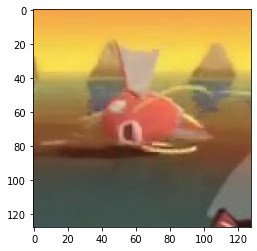

In [18]:
processed = prepare_img(screenshots[274])
print(processed.shape)
plt.imshow(processed)

In [19]:

def decode_one(x, threshhold = 0.5):
    return 1 if x > threshhold else 0

def predict_one(path):
    processed = prepare_img(path)
    data = np.array([processed])
    pred_raw = prediction_model.predict(data)
    prediction = decode_one(pred_raw)
    return prediction


In [23]:
d = prepare_img(screenshots[9953])
d = np.array([d])
pred_raw = prediction_model.predict(d)
prediction = decode_one(pred_raw)
prediction

1

In [24]:
predictions = []

for path in screenshots:
    pred = predict_one(path)
    predictions.append(pred)

In [25]:
print("Total number of predictions", len(predictions))
print("Total number of AKAI KOI", len([p for p in predictions if p > 0]))

Total number of predictions 10369
Total number of AKAI KOI 1579


In [26]:
freqs = []

current = 0

for p in predictions:
    if p == 0:
        current = 0
    else:
        current += 1
    freqs.append(current)



<BarContainer object of 10369 artists>

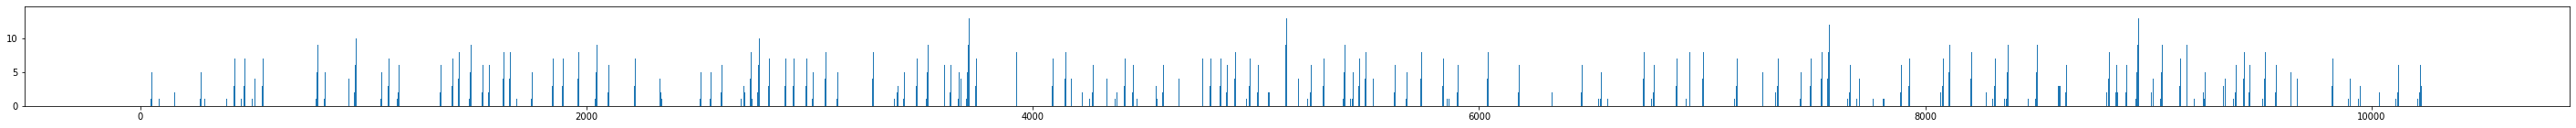

In [27]:
plt.figure(figsize=(50, 2))
plt.bar([i for i in range(len(freqs))], freqs)

In [32]:
filtered = [i for i, f in enumerate(freqs) if f >= 6]

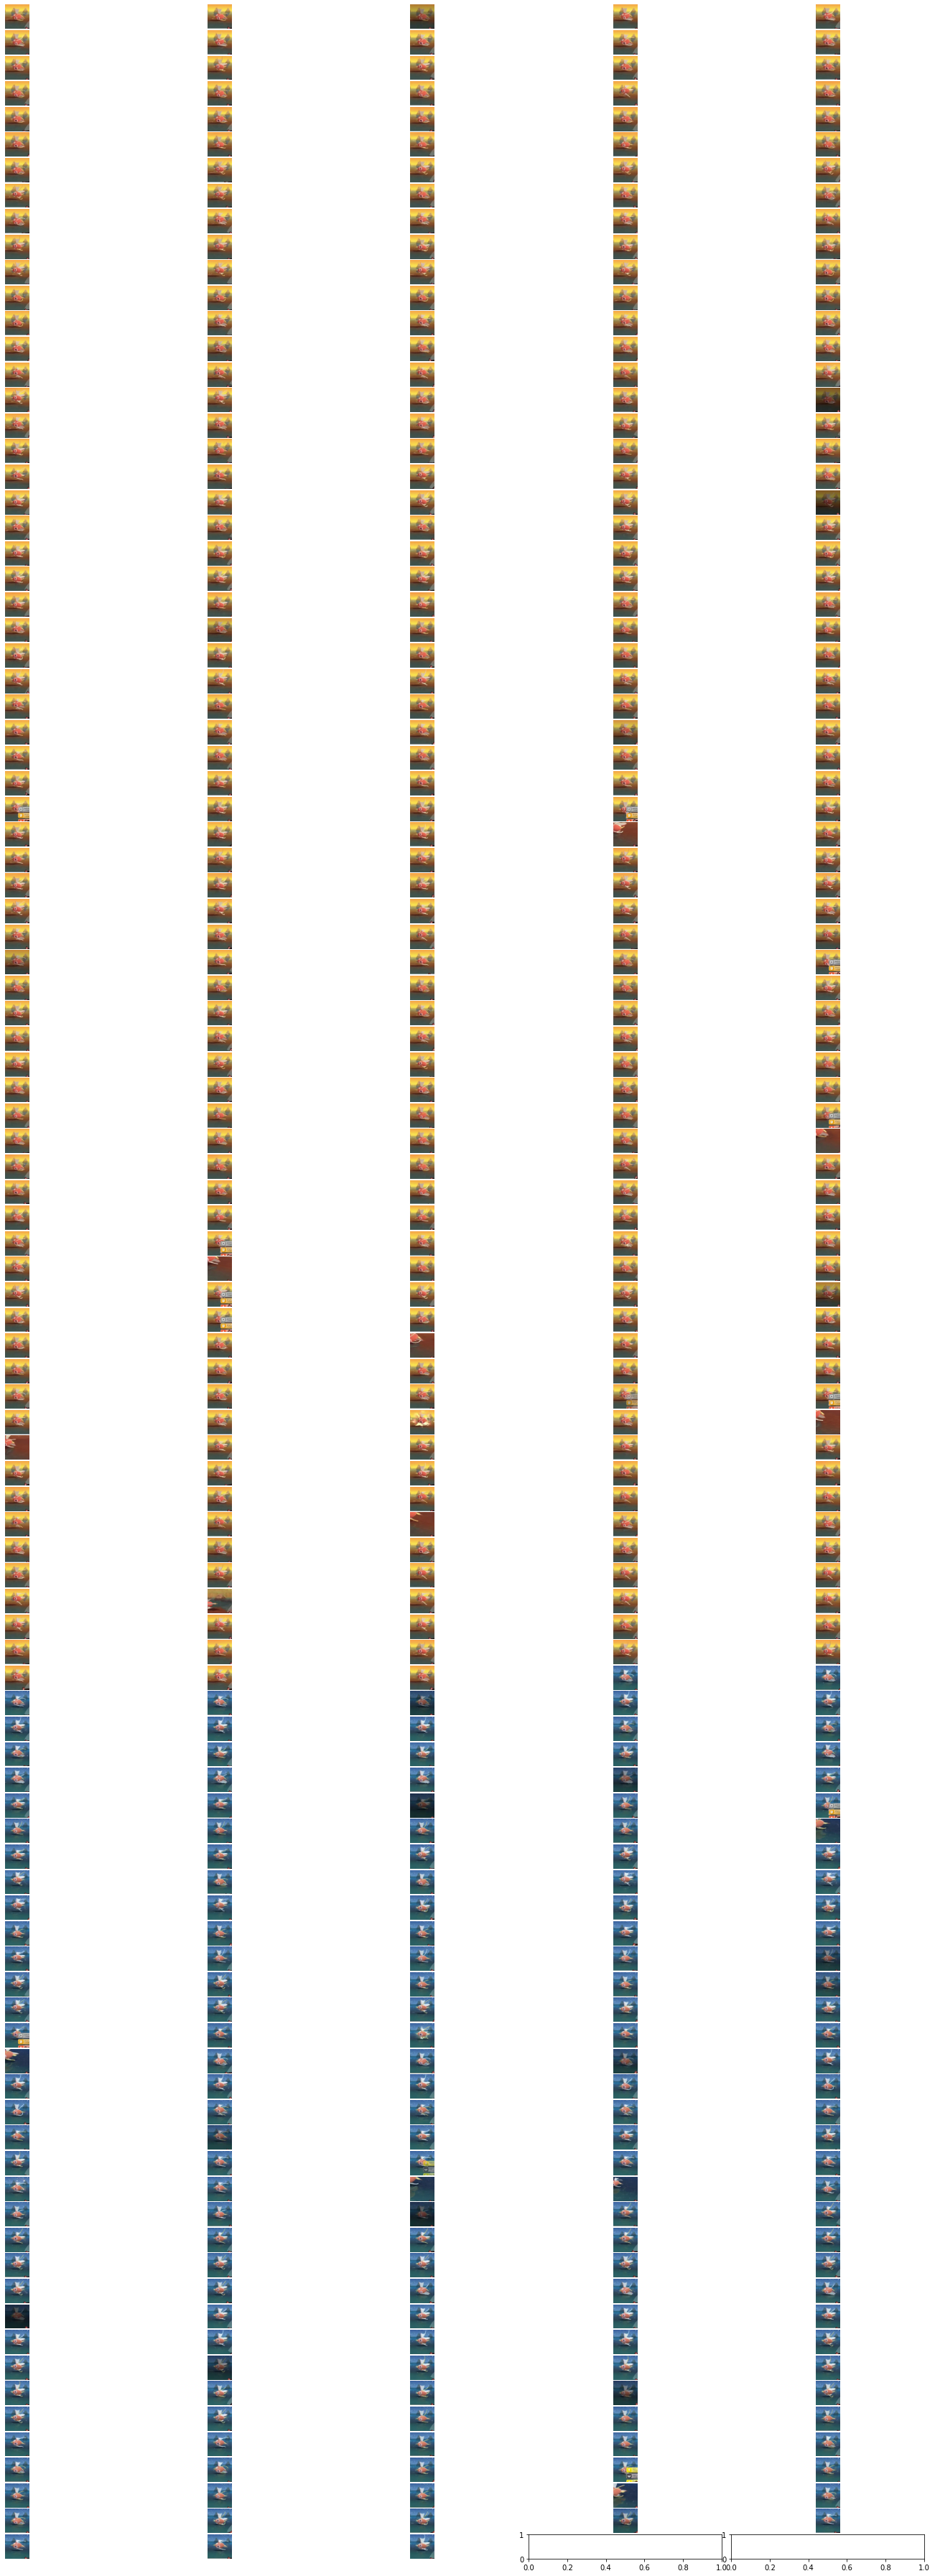

In [45]:
from PIL import Image

fig, ax = plt.subplots((len(filtered) // 5) + 1, 5, figsize=(20, 50))
fig.tight_layout() 
for i, idx in enumerate(filtered):
    ax[i // 5, i % 5].imshow(prepare_img(screenshots[idx]))
    ax[i // 5, i % 5].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)